# 나랑 닮은 연예인을 찾아보자
준비된 이미지 중에서 가장 닮은 사람의 얼굴을 찾아보자.

## 0. 모듈 import

In [1]:
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ipywidgets import interact
from matplotlib import offsetbox
from PIL import Image
import ipyvolume as ipv
import ipyvolume.pylab as p3
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import frontalize
import facial_feature_detector as feature_detection
import camera_calibration as calib
import check_resources as check
import scipy.io as io
import face_recognition
import cv2
import os

## 1. 사진 모으기
연예인 사진은 수희 퍼실님이 올려주신 모음 사진을 다운 받았다.  

https://drive.google.com/file/d/1SCNlkW3l9bzsGhzFVk8DmNdfq9D-sey2/view

내 사진은 2장 찍어서 업로드 하였다.

## 2. 얼굴 영역 자르기

다음은 이미지 주소를 받아서 이미지에서 인식된 얼굴을 사각형으로 잘라 반환하는 함수이다.

이미지의 얼굴을 인식하지 못해서 바운딩 박스를 생성하지 못하는 경우의 예외를 처리하였다.

In [2]:
def get_cropped_face(image):
    face_locations = face_recognition.face_locations(image)
    
    # 하나의 얼굴만 인식한다고 가정한다.
    l, b, r, t = face_locations[0]
    cropped_face = image[l:r,t:b,:]
    
    return cropped_face


def crop_images(images_path, save_path):
    file_list = os.listdir(images_path)
    for file in file_list:
        img_path = os.path.join(images_path, file)
        try:
            image = face_recognition.load_image_file(img_path)
        except:
            print(f'이미지 로드 실패 : {img_path}')
            continue
        
        try:
            cropped_face = get_cropped_face(image)
        except:
            print(f'얼굴 바운딩 박스 찾기 실패 : {img_path}')
            continue
            
        filename = os.path.splitext(file)[0] # 확장자를 제거한 이미지 파일이름
        
        # 임베딩까지 된 이미지는 나중에 시각화를 위해서 따로 저장한다.
        pillow_image = Image.fromarray(cropped_face)
        pillow_image.save(save_path+f'/{filename}.png')

함수를 통해 반환된 이미지를 출력해보자.

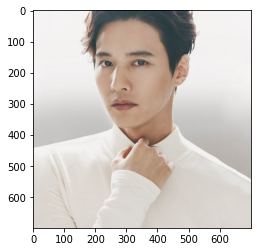

In [3]:
image_path = os.getenv('HOME')+'/aiffel/Exploration/E05_FindSimilarCelebrities/data/images/원빈.jpg'
image = img.imread(image_path)
plt.imshow(image)

얼굴 바운딩 박스 찾기 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/images/산들.jpeg
이미지 로드 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/images/.ipynb_checkpoints


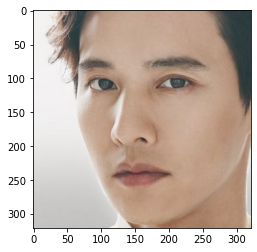

In [4]:
images_path = os.getenv('HOME')+'/aiffel/Exploration/E05_FindSimilarCelebrities/data/images'
cropped_face_path = os.getenv('HOME')+'/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces'

crop_images(images_path, cropped_face_path)
    
image = img.imread(cropped_face_path + '/원빈.png')
plt.imshow(image)
plt.show()

## 3. 얼굴 영역의 임베딩 추출하기

위에서 만든 함수를 이용해서 이미지들을 잘라서 만든 얼굴 이미지를 임베딩하자.

모든 이미지를 임베딩하면서 만들어진 잘려진 얼굴 이미지는  
나중에 시각화를 위해서 따로 저장하도록 하였다.

In [5]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    for file in file_list:     
        try:
            img_path = os.path.join(dir_path, file)
            image = face_recognition.load_image_file(img_path)
            embedding = face_recognition.face_encodings(image) # 얼굴 이미지 임베딩

            # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            if len(embedding) > 0:  
                filename = os.path.splitext(file)[0] # 확장자를 제거한 이미지 파일이름
                embedding_dict[filename] = embedding[0]
            else:
                print(f'이미지 임베딩 실패 : {img_path}')
                
        except:
            print(f'예외 발생 : {img_path}')
        
    return embedding_dict

In [6]:
embedding_dict = get_face_embedding_dict(cropped_face_path)

이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/사무엘 L 잭슨.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/도아.png
예외 발생 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/.ipynb_checkpoints
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/신태용.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/김대명.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/신비.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/제프리 힌턴.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/이승환.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/한효주.png
이미지 임베딩 실패 : /aiffel/aiffel/Exploration/E05_FindSimilarCelebrities/data/cropped_faces/매드클라운.png


준비한 이미지 중에서 하나는 얼굴의 사각형을 찾지 못했고,  
나머지는 얼굴의 바운딩박스에 임베딩을 하는 과정에서 완료하지 못하였다.

그럼 일단 만들어진 임베딩된 데이터들이 128벡터로 제대로 되었는지 확인하여보자.

In [7]:
print(f' 임베딩된 데이터 개수 : {len(embedding_dict)}\n')
print(f"임베딩된 벡터: {embedding_dict['나1']}")
embedding_dict['나1'].shape

 임베딩된 데이터 개수 : 273

임베딩된 벡터: [-0.0711 0.0602 0.0452 0.0150 -0.0771 -0.0844 -0.0676 -0.1615 0.1033
 -0.0747 0.2374 -0.0759 -0.1669 -0.0912 -0.0401 0.1823 -0.1585 -0.1362
 -0.0497 -0.0024 0.0993 0.0106 -0.0046 0.0480 -0.1013 -0.2971 -0.1103
 -0.0797 0.0032 -0.0758 -0.0109 0.0581 -0.1835 -0.0443 0.0539 0.0430
 0.0041 -0.0710 0.1891 -0.0476 -0.2457 0.0811 0.0963 0.2129 0.1293 0.0185
 0.0108 -0.2023 0.1306 -0.0945 0.0564 0.1523 0.1143 0.0760 -0.0122 -0.1327
 0.0325 0.1281 -0.1340 0.0257 0.1005 -0.0344 -0.0425 -0.0925 0.1840 0.0611
 -0.1110 -0.1835 0.0702 -0.1296 -0.1057 0.0688 -0.1603 -0.1832 -0.3062
 -0.0028 0.3524 0.0062 -0.2592 0.0569 -0.0276 -0.0065 0.1208 0.1617
 -0.0101 0.0013 -0.0615 -0.0120 0.2476 -0.0629 0.0098 0.2181 0.0101 0.0407
 0.0111 0.0203 -0.0358 0.0339 -0.1016 -0.0129 0.0273 -0.0115 -0.0422
 0.0851 -0.1856 0.1282 0.0476 0.0475 0.0561 0.0025 -0.0879 -0.0824 0.1246
 -0.2253 0.2274 0.1369 0.0742 0.0933 0.0874 0.1281 -0.0292 -0.0059 -0.2135
 0.0187 0.1447 -0.0373 0.0335 -0.012

(128,)

## 4. 모은 연예인들과 비교하기

위에서 만든 임베딩된 딕셔너리를 통해서 내 사진과 비교를 해서 가장 닮은 얼굴을 찾아보자.

닮은 얼굴을 찾기 위해 임베딩된 벡터간의  L2 Norm Distance를 구한다.

$$ d(p,q)=d(q,p)=\sqrt{(q_1−p_1)^2+(q_2−p_2)^2+⋅⋅⋅+(q_n−p_n)^2}= \sqrt{\sum_{i=1}^n(q_i - p_i)^2} $$

다음은 임베딩 딕셔너리에서 이름을 입력으로 받아, L2 Norm Distnace가  
가장 짧은(가장 닮은) 5개의 이미지를 찾아주는 함수이다.

In [8]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)
    return get_distance_from_name1

In [9]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
    
    return sorted_faces

In [10]:
nearest_faces = get_nearest_face('나1')

순위 1 : 이름(나2), 거리(0.25976490900888083)
순위 2 : 이름(개리), 거리(0.3981126611987793)
순위 3 : 이름(윤경신), 거리(0.4049414549135658)
순위 4 : 이름(이희준), 거리(0.4082907437032635)
순위 5 : 이름(슈퍼비), 거리(0.4120820911066399)


가장 닮은 이미지가 다르게 찍은 나의 사진이 나온걸로 보아 결과가 괜찮은 것 같다.  
그렇다면 다른 사진으로 가장 닮은 사람을 찾아보면 결과가 어떻게 나올지 확인해보자.

In [11]:
nearest_faces = get_nearest_face('나2')

순위 1 : 이름(나1), 거리(0.25976490900888083)
순위 2 : 이름(정수빈), 거리(0.38405658197434)
순위 3 : 이름(슈퍼비), 거리(0.39084090744990363)
순위 4 : 이름(개리), 거리(0.39856482608006744)
순위 5 : 이름(이희준), 거리(0.4126808995767135)


## 5. 다양한 재미있는 시각화 시도해 보기
위의 정보들을 사용해서 다양한 시각화를 시도해 보자.

### 알파 블렌드를 이용한 페이드 효과

시각화에 대해 고민하던 중 닮은 이미지와 얼마나 비슷한지 직접 대조하는 방법이 떠올랐다.  
닮은 두 이미지를 겹쳐 알파 블렌드로 합치고, 그것에 페이드 효과를 넣어보자.

그전에 각 얼굴을 정면방향으로 정렬시켜야 한다.  
https://github.com/dougsouza/face-frontalization  
위 링크의 라이브러리를 이용해서 이미지를 정면으로 돌린다.  

원리는 랜드마크로 인식한 점으로부터 얼굴의 변환 행렬을 구하고,  
그것으로 부터 다시 얼굴의 각 폴리곤을 텍스쳐로서 정면 행렬로 돌리는 것 같다.

In [12]:
def get_frontalized_face_image(img_path):
    check.check_dlib_landmark_weights()
    model3D = frontalize.ThreeD_Model(os.getenv('HOME') + '/aiffel/Exploration/E05_FindSimilarCelebrities/frontalization_models/model3Ddlib.mat', 'model_dlib')

    img = face_recognition.load_image_file(img_path)
    lmarks = feature_detection.get_landmarks(img)

    proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])

    eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
    frontal_raw, frontal_sym = frontalize.frontalize(img, proj_matrix, model3D.ref_U, eyemask)
    return frontal_raw

Number of faces detected: 1
query image shape: (800, 800, 3)


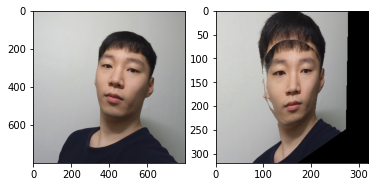

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img.imread(images_path + '/나1.jpg'))
axes[1].imshow(get_frontalized_face_image(f'{images_path}/나1.jpg'))
plt.show()

아무래도 단순히 텍스쳐를 회전변환만 시키다 보니 일그러진 부분이나,  
어색한 부분이 있지만 여기서 다시 얼굴을 잘라서인식해보자.

Number of faces detected: 1
query image shape: (800, 800, 3)


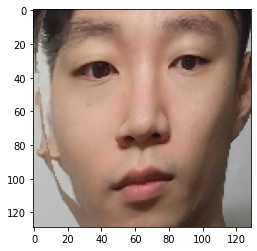

In [14]:
def get_front_face(img_path):
    result = get_cropped_face(get_frontalized_face_image(img_path))
    
    return result

cropped_face = get_front_face(f'{images_path}/나1.jpg')
plt.imshow(cropped_face)
plt.show()

그럼 이제 준비된 함수들을 이용해서 가장 닮은 얼굴 5명과의 이미지로 페이드 효과를 나타내보자.

In [15]:
def get_blend_image(img_src, img_dst, alpha):
    return img_src*(1-alpha) + img_dst*alpha

Number of faces detected: 1
query image shape: (542, 480, 3)
Number of faces detected: 1
query image shape: (800, 800, 3)
Number of faces detected: 1
query image shape: (682, 500, 3)
Number of faces detected: 1
query image shape: (460, 300, 3)
Number of faces detected: 1
query image shape: (900, 600, 3)
Number of faces detected: 1
query image shape: (512, 341, 3)


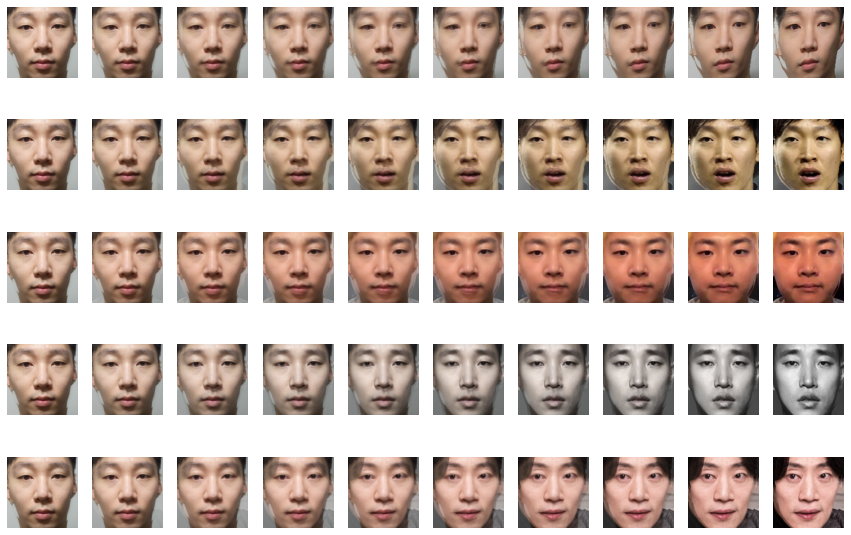

In [16]:
fade_size = 10

fig, axes = plt.subplots(5, fade_size)
fig.set_size_inches(15, 10)

img_src = get_front_face(f'{images_path}/나2.jpg')

for i, ax_row in enumerate(axes, start=1):
    img_dst = get_front_face(f'{images_path}/{nearest_faces[i][0]}.jpg')
    img_dst = cv2.resize(img_dst,  dsize=img_src.shape[0:2])
    
    for alpha, ax in zip(np.linspace(0., 1., fade_size), ax_row):
        ax.imshow(get_blend_image(img_src, img_dst, alpha).astype(np.int32))
        ax.set_axis_off()

간단하게 상호작용 가능한 슬라이더로 표현해보았다.

In [17]:
img_dst = get_front_face(f'{images_path}/{nearest_faces[2][0]}.jpg')
img_dst = cv2.resize(img_dst,  dsize=img_src.shape[0:2])

@interact(x=(0.0, 1.0))
def fade_slider(x):
    plt.imshow(get_blend_image(img_src, img_dst, x).astype(np.int32))
    plt.show()

Number of faces detected: 1
query image shape: (682, 500, 3)


interactive(children=(FloatSlider(value=0.5, description='x', max=1.0), Output()), _dom_classes=('widget-inter…

### 얼굴임베딩 공간의 시각화

노드 자체에 올라와 있던 3차원 시각화 아이디어를 그대로 사용해보자.

차원축소를 통해서 128차원의 벡터를 3차원이나 2차원으로 축소 시키면 시각화가 가능하다.  
차원 축소 방법은 여러가지 있지만, 여기서 대표적으로 PCA와 T-SNE을 사용해보자.

In [18]:
# PCA로 3차원으로 차원 축소를 시킨다.
def get_PCA_vectors(vectors, n_dimension):
    model_pca = PCA(n_components=n_dimension)
    result_vectors = model_pca.fit_transform(vectors)
    return result_vectors

In [19]:
vectors_128d = np.array(list(embedding_dict.values()))

cropped_faces = []
for name in embedding_dict.keys():
    cropped_faces.append(Image.open(f'{cropped_face_path}/{name}.png'))
    
len(cropped_faces)

273

3차원으로 만든 벡터들의 각 위치에 이미지를 그리면된다.

3차원 그래프를 ipywidgets를 이용해서 산점도로 그릴 생각이었지만,  
주피터 노트북 상에서 그래프가 나오지 않는 문제를 해결을 못해서 ipyvolumn으로 그렸다.

문제는 ipyvolumn 라이브러리는 아무리 찾아봐도 산점도에 주석을 넣는 부분이 없어서  
어쩔수 없이 z축에 수직으로 이미지로 그렸고, 쥬피터 노트북에 상태 저장이 안되서 html로 저장하여 처리하였다.

용량 문제로 github에 올라가지 않아 이미지로 대체하였다.

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

def create_3d_graph(vectors_3d, cropped_faces, save_path, image_size):
    #fig = ipv.figure()

    #u = np.array([0.0, 1.0, 1.0, 0.0])
    #v = np.array([0.0, 0.0, 1.0, 1.0])

    #for vec, texture in zip(vectors_3d, cropped_faces):
    #    x = np.array([vec[0], vec[0]+image_size, vec[0]+image_size, vec[0]])
    #    y = np.array([vec[1], vec[1], vec[1]+image_size, vec[1]+image_size])

    #    ipv.plot_trisurf(x, y, vec[2], triangles=[[0, 1, 2], [0, 2, 3]], u=u, v=v, texture=texture)

    #p3.save(save_path)
    #plt.clf()
    
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vectors_3d[:,0], vectors_3d[:,1], vectors_3d[:,2])

    ax2 = fig.add_subplot(111,frame_on=False) 
    ax2.axis("off")
    ax2.axis([0,1,0,1])

    for img, pos in zip(cropped_faces, vectors_3d):
        x,y,z = pos
        x2, y2, _ = proj3d.proj_transform(x,y,z, ax.get_proj())
        p = ax2.transData.inverted().transform(ax.transData.transform((x2, y2))) 
        
        img_arr = np.array(img.resize([image_size, image_size], Image.ANTIALIAS))
        img_box = offsetbox.OffsetImage(img_arr, zoom=2)
        img_box.image.axes = ax
        imagebox = offsetbox.AnnotationBbox(img_box, p)
        ax2.add_artist(imagebox)
    
    plt.show()

(273, 3)


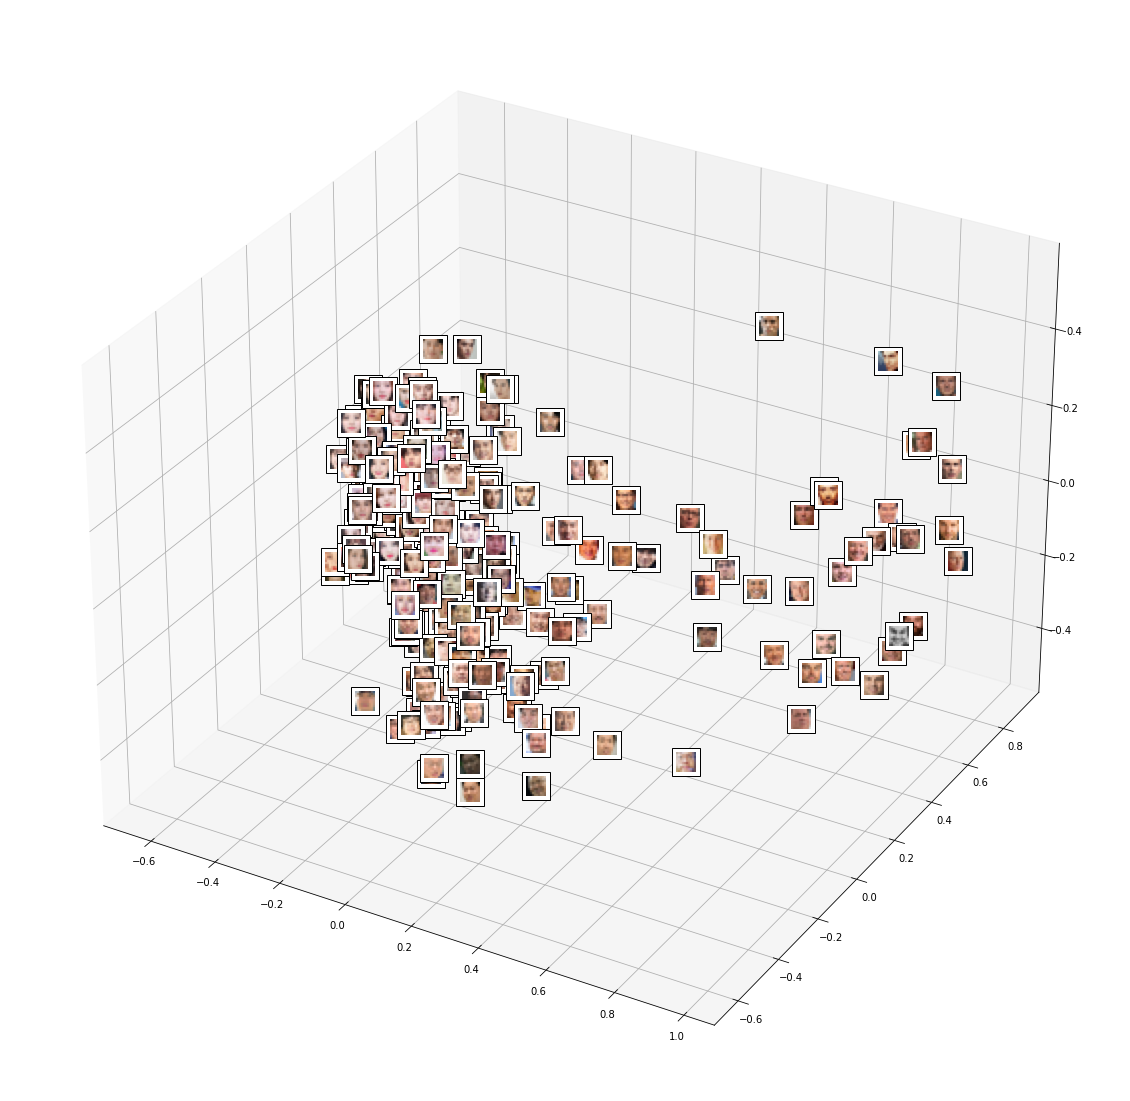

In [21]:
vectors_3d = get_PCA_vectors(vectors_128d, 3)
print(vectors_3d.shape)

html_path = os.getenv('HOME')+'/aiffel/Exploration/E05_FindSimilarCelebrities'
create_3d_graph(vectors_3d*2, cropped_faces, html_path + '/embedding_vector_graph_PCA.html', 10)
#HTML(open(html_path + '/embedding_vector_graph_PCA.html').read())

[PCA 3d 그래프](embedding_vector_graph_PCA.html)

2차원으로도 그려보자.

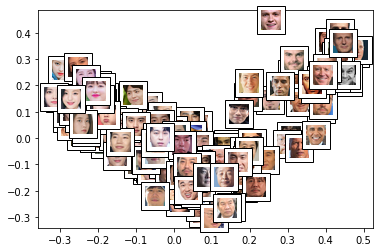

In [22]:
vectors_2d = get_PCA_vectors(vectors_128d, 2)
ax = plt.subplot()
ax.scatter(vectors_2d[:,0], vectors_2d[:,1])

for img, pos in zip(cropped_faces, vectors_2d):
    img_arr = np.array(img.resize([20, 20], Image.ANTIALIAS))
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img_arr, cmap=plt.cm.gray_r), pos)
    ax.add_artist(imagebox)

다음으로는 T-SNE으로 차원 축소를 실행시켜서 그려보자.

In [23]:
# T-SEN으로 3차원으로 차원 축소를 시킨다.
def get_TSNE_vectors(vectors, n_dimension):
    model_TSNE = TSNE(n_components=n_dimension)
    result_vectors = model_TSNE.fit_transform(vectors)
    return result_vectors

(273, 3)


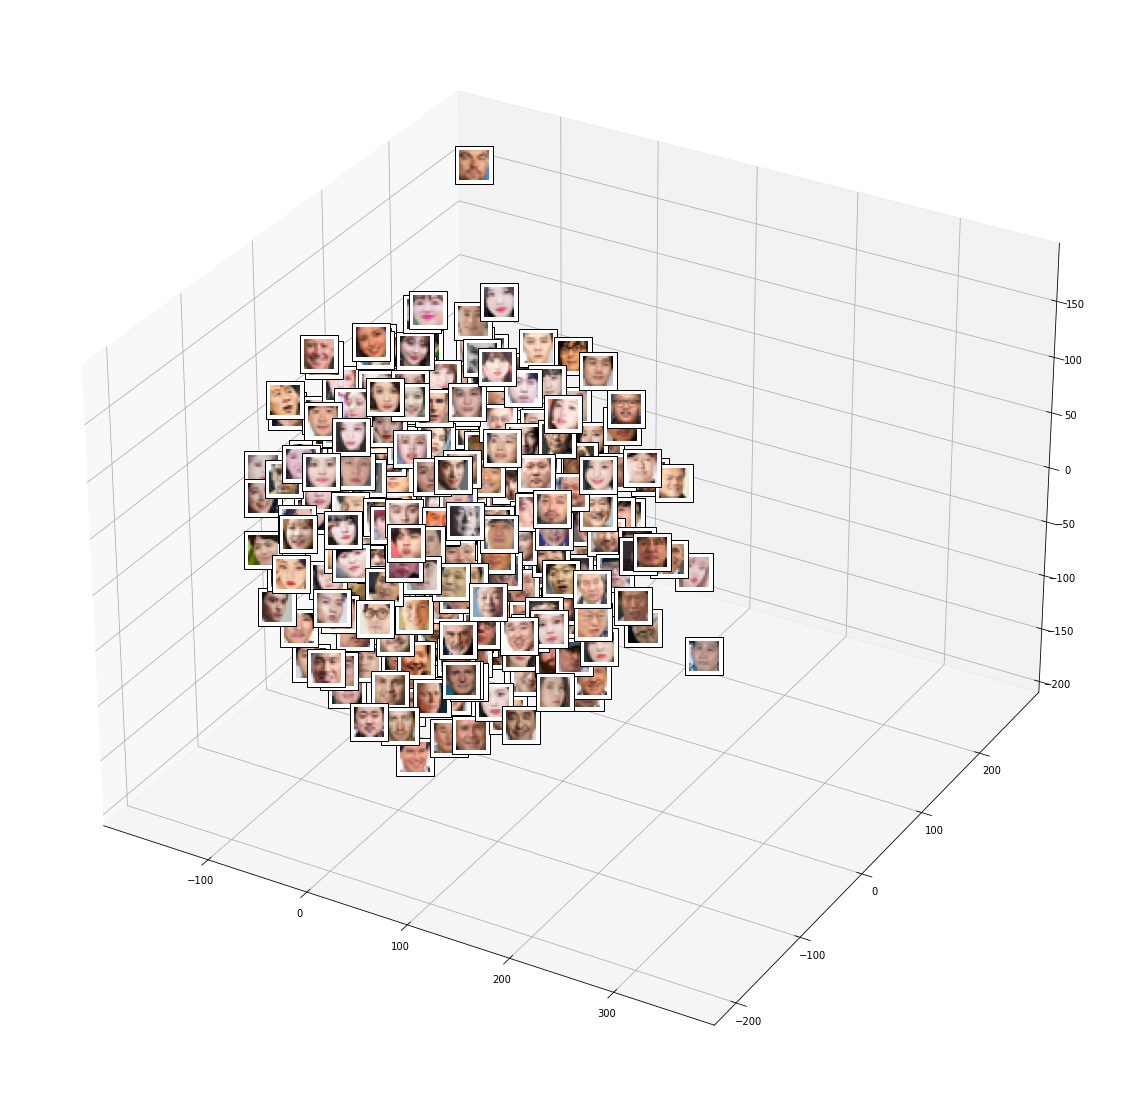

In [24]:
vectors_3d = get_TSNE_vectors(vectors_128d,3 )
print(vectors_3d.shape)

create_3d_graph(vectors_3d, cropped_faces, html_path + '/embedding_vector_graph_TSNE.html', 15)
#HTML(open(html_path + '/embedding_vector_graph_TSNE.html').read())

[TSNE 3d 그래프](embedding_vector_graph_TSNE.html)

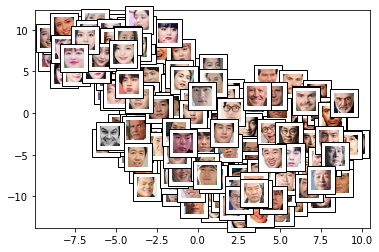

In [25]:
vectors_2d = get_TSNE_vectors(vectors_128d, 2)
ax = plt.subplot()
ax.scatter(vectors_2d[:,0], vectors_2d[:,1])

for img, pos in zip(cropped_faces, vectors_2d):
    img_arr = np.array(img.resize([20, 20], Image.ANTIALIAS))
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img_arr, cmap=plt.cm.gray_r), pos)
    ax.add_artist(imagebox)

## 6. 개인적인 정리

이번에 크게 중요하게 봐야 할 것은 임베딩된 벡터가 무엇인지 어떻게 구하는지,  
임베딩을 하기 위한 모델을 학습시키는 과정이라고 생각한다.

### 임베딩이란?
내가 이해한 바로는 임베딩이란 입력이 모델을 통해 결과를 내는 과정에서  
나오는 특징같은거라고 생각한다.

간단한 cnn을 예로 들자면, 입력 데이터(이미지, 필터링된 이미지)는  
정해진 필터들을 통해 여러 필터링된 이미지를 만들게 된다.  
밑의 과정은 들어간 이미지를 소벨 필터를 통해 필터링된 이미지 2개를 출력한 것이다.

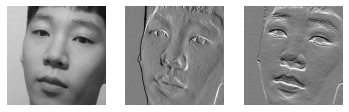

In [26]:
src = cv2.imread(f'{cropped_face_path}/나1.png', cv2.IMREAD_GRAYSCALE)

dx = cv2.Sobel(src, -1, 1, 0, delta=128)
dy = cv2.Sobel(src, -1, 0, 1, delta=128)

fig, axes = plt.subplots(1, 3)
[ax.set_axis_off() for ax in axes]

axes[0].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(dx, cv2.COLOR_BGR2RGB))
axes[2].imshow(cv2.cvtColor(dy, cv2.COLOR_BGR2RGB))

소벨 필터는 다음과 같이 소벨이라는 사람이 고안한 필터로  
convolution을 통해 이미지의 x, y의 경계를 남기게 된다.
![nn](data/filters.png)

이처럼 필터를 통해 이미지에서 특정 특징만을 가진 데이터를 여러개 뽑아낼 수 있는데,  
cnn은 저런 필터들을 컴퓨터에게 학습시켜서 만들어내게 하는 것이라고 봐도 무방하다.  
주어진 오차값을 최소로 줄이는 방향으로 필터들을 수정하면서 인간이 만들어낸것이 아닌  
학습 데이터들을 가장 잘 분류 할 수 있는 필터가 만들어지는 것이다.

위의 소벨 필터를 통해 나온 결과는 직관적으로 x, y 변화(경계)를 잘 나타내는 결과라고 말할 수 있다면,  
cnn의 하나의 필터를 통해 나온 결과는 '둥그스레한 정도를 약화시킨 푸르딩딩함 정도'같이 추상적이다.

cnn은 이름처럼 이미지에 필터링된 결과값을 비선형 함수를 거쳐 새로운 입력으로 넣게된다.  
그렇게 나온 각 레이어의 필터링된 출력값은 사람의 기준으로 보기에는 매우 추상적인 것이 된다.  

그렇게 여러 층을 거쳐 마지막 분류를 위한 레이어를 통과하기 전의 출력값은 n개의 벡터가 될 것이다.  
그 벡터는 매우 추상적이지만, 하나 하나의 값이 이미지를 분류하기 위한 결정적인 특징들이 될 것이다.  
이 벡터를 구하는 과정을 임베딩이라고 나는 이해하였다.

### 임베딩 모델을 구하는 과정

이번 프로젝트를 하면서 참조한 deepface와 facenet의 내용이다.  
https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf
https://arxiv.org/abs/1503.03832

deepface에서 임베딩 모델을 학습시키는 과정은 다음 그림처럼 단순한 알렉스넷 기반의  
네트워크를 통해 이미지 분류로 학습을 시켰다.
![nn](data/deepface.jpg)

오차를 구하는 과정에서는 cross-entropy를 통한 오차 뿐만 아니라, 같은 이미지 간의  
출력된  4096의 벡터의 chi-squere distance를 더해서 오차를 계산하였다.

그리고 그렇게 학습된 모델에서 나오는 4096벡터가 임베딩 벡터라고 할 수 있다.
![nn](data/deepface2.jpg)


facenet은 deepface와는 다르게 Triplet Loss를 구해서 학습을 시킨다.  
즉, 3개의 이미지를 이용해서 같은 id 이미지의 임베딩 벡터 distance는 작게,  
다른 id 이미지의 임베딩 벡터 distance는 크도록 학습시킨다는 것이다.
![nn](data/faceNet.png)

여기서 직관적으로 생각해보면 faceNet이 deepface보다 verification, clustering등이  
더 좋은 성능을 내는 이유를 알 수 있다.  

deepfcae의 임베딩 벡터는 chi-squere distance로 비슷한 이미지를 가깝게 줄이기는 했지만,  
각 벡터의 값은 분류를 기준으로 학습된 값들이다.  
그에 반해 faceNet은 애초에 임베딩 벡터를 거리를 기준으로 학습을 시켰기 때문에  
나온 결과의 임베딩 벡터가 이미지들의 거리를 더 잘 표현하는 것이라고 생각한다.


## 7. 회고

이번 프로젝트를 통해서 임베딩에 대해 좀 더 잘 알게된 것 같다.  
특히 faceNet등을 보면서 오차를 어떻게 설정하는가에 따라 학습된 모델의 결과가  
어떻게 달라질 수 있는지에 대해 직관적인 이해를 얻는 것 같다.

거기에 단순히 identification뿐만 아니라 verification이나 clustering 등의  
방법도 좀 더 알게된 것 같다.

아쉬웠던 점은 주피터 노트북이나, github의 문제로 상호작용가능한 3d그래프를 그리지 못하였다.